# Assignment 1

## Question `2` (Decision Trees)

| | |
|-|-|
| Course | Statistical Methods in AI |
| Release Date | `19.01.2023` |
| Due Date | `31.01.2023` |

This assignment will have you working and experimenting with decision trees. Initially, you will be required to implement a decision tree classifier by choosing thresholds based on various impurity measures and reporting the scores. Later, you can experiment with the `scikit-learn` implementation of decision trees, and how various other parameters can be leveraged for better performance.

The dataset is a very simple one, the [banknote authentication dataset](https://archive.ics.uci.edu/ml/datasets/banknote+authentication). It has 5 columns, the first 4 are the features, and the last one is the class label. The features are the variance, skewness, curtosis and entropy of the [wavelet transformed](https://en.wikipedia.org/wiki/Wavelet_transform) image of the banknote. The class label is 1 if the banknote is authentic, and 0 if it is forged. The data is present in `bankAuth.txt`. There are a total of 1372 samples in the dataset.

### Announcements
1. In the sections titled "Impurity Measures" and "Decision Tree", no external libraries are allowed. In the section titled "sklearn Decision Tree Experiments", you need to use the sklearn functions.

2. Entropy and log loss, both of these impurities are the same.


In [46]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Imports

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
# sklearn imports have not been used in the initial parts of the assignment, as told.
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import tree

# additional imports if necessary

### Impurity Measures

Decision trees are only as good as the impurity measure used to choose the best split. In this section, you will be required to implement the following impurity measures and use them to build a decision tree classifier.

1. Gini Index
2. Entropy
3. Misclassification Error
4. Log Loss

NOTE: Entropy and Log Loss are the same

Impurity refers to the fact that, when we make a cut, how likely is it that the target variable will be classified incorrectly.

**The Gini index** is the most widely used cost function in decision trees. This index calculates the amount of probability that a specific characteristic will be classified incorrectly when it is randomly selected.
This is an index that ranges from 0 (a pure cut) to 0.5 (a completely pure cut that divides the data equally). The Gini index is calculated as follows:

$Gini = 1 - \sum _{i=1}^n(P_i)^2$

Where Pi is the probability of having that class or value.

---

**Entropy** can be defined as a measure of the purity of the sub split. It is a way of measuring impurity or randomness in data points. Range goes from 0 to 1. In this way, values close to zero are less impure than those that approach. Entropy is defined by the following formula:

$E(S) = \sum _{i=1}^c -p_ilog_2p_i$

---
The **misclassification loss** computes the fraction of misclassified samples. Given by the following formula:

$MC = 1 - max_{i \in I} P_i$

---

Write functions that calculate the impurity measures for a given set of labels. The functions should take in a list of labels and return the impurity measure.

In [48]:
# your code here
def impurity_calculator(labels_list, impurity_choice):
  p = labels_list.value_counts()/labels_list.shape[0]
  # print(p)
  if(impurity_choice=='gini'):
    impurity_measure = 1 - np.sum(p**2)
  elif(impurity_choice=='entropy'):
    impurity_measure = np.sum(-p*np.log2(p+1e-9))
  else:
    impurity_measure = 1 - np.max(p)
  return impurity_measure



We are interested in comparing those cuts that generate less impurity. For this, Information Gain is used, which indicates the improvement when making different partitions and is usually used with entropy.

$InfoGain_{Classification} = E(d) - \sum \frac{|s|}{|d|}E(s)$

In [49]:
def information_gain(y, mask, impurity_choice, func = impurity_calculator):
  '''
    This functon returns the Information Gain of a variable given a loss function.
    y: target variable.
    mask: split choice.
    func: function to be used to calculate Information Gain (in case of classification)
  '''
  a = sum(mask)
  b = mask.shape[0] - a
  
  # choose impurity measure here
  # impurity_choice = 'gini'
  
  if(a == 0 or b == 0):
    return 0
  else:
    return func(y, impurity_choice) - a/(a+b)*func(y[mask], impurity_choice)-b/(a+b)*func(y[-mask], impurity_choice)


In [50]:
import itertools

def max_ig_split(x, y, impurity_choice):

  # x: labels to be predicted
  # y: target feature/variable as Pandas Series.
  # func: impurity measure to be used to calculate the best split.

  split_value = []
  infogain = [] 
  options = x.sort_values().unique()[1:]
  # print("inside max split func ", options)
  for i in options:
    mask = x < i
    value = information_gain(y, mask, impurity_choice)
    # Append results
    infogain.append(value)
    split_value.append(i)
  
  best_ig = max(infogain)
  best_ig_index = infogain.index(best_ig)
  best_split = split_value[best_ig_index]
  return(best_ig, best_split)



### Decision Tree

Fit a decision tree using any one of the above impurity measures with a depth of 3. This means you will have eight leaf nodes and seven internal nodes. Report the threshold values at each internal node and the impurity measure at the final leaf node with the label. Also report the accuracy of the classifier on the training and test data (instructions for splitting the data will be given in the end).

In [51]:
column_names = ['variance', 'skewness', 'curtosis', 'entropy', 'label']
data = pd.read_csv('drive/MyDrive/bankAuth.txt', names = column_names)

In [52]:
# data
# impurity_calculator(data.label, 'gini')

weight_infogain, weight_split = max_ig_split(data['entropy'], data['label'], 'gini')  


print("using the gini index, the best split is when variable is less than ", weight_split," and \ncorresponding information gain for that split is:", weight_infogain)

using the gini index, the best split is when variable is less than  1.6168  and 
corresponding information gain for that split is: 0.002440317766184367


In [53]:
check = data.drop('label', axis= 1).apply(max_ig_split, y = data['label'], impurity_choice = 'gini')
# print("listen here you fat fudge: ", check.loc[1,:])
data
print(check)

   variance  skewness  curtosis  entropy
0  0.247064  0.116609   0.04677  0.00244
1  0.322300  5.181500   8.70860  1.61680


- the first split can be done from variance, based on the gini index impurity measure.
- to avoid overfitting, we shall use some hyperparameters for our job.
  - max_depth
  - min_samples_split
  - min_information_gain

In [54]:
def best_split_calculator(y, data, impurity_measure):

  '''
    y: name of the target variable
    data: dataframe where to find the best split.
  '''
  masks = data.drop('label', axis= 1).apply(max_ig_split, y = data['label'], impurity_choice = impurity_measure)
  print("baby, sharks ", masks)
  np_masks = np.array(masks.iloc[0])
  print(np_masks)

  max_index = np_masks.argmax()
  if max_index == 0:
    split_variable = 'variance'
  elif max_index == 1:
    split_variable = 'skewness'
  elif max_index == 2:
    split_variable = 'curtosis'
  else: 
    split_variable = 'entropy'
  
  # results for split with highest IG
  print("split variable \n", split_variable)
  split_ig = masks[split_variable][0]
  split_value = masks[split_variable][1] 

  return(split_variable, split_value, split_ig)
  
def make_split(variable, value, data):
  
  # Given a data and a split conditions, do the split.
  # variable: variable with which make the split.
  # value: value of the variable to make the split.
  # data: data to be splitted.
  
  return (data[data[variable] < value], data[(data[variable] < value) == False])

def make_prediction(data, target_factor):
  
  # Given the target variable, make a prediction.
  # data: pandas series for target variable
  # target_factor: boolean considering if the variable is a factor or not
  
  # Make predictions
  if target_factor:
    return data.value_counts().idxmax()
  else:
    return data.mean()


In [55]:
def train_tree(impurity_measure, data, y, target_factor, max_depth = None, min_samples_split = None, min_information_gain = 1e-20, counter = 0):
  
  bool_mere = [True, False]
  # Trains a Decision Tree
  # data: Data to be used to train the Decision Tree
  # y: target variable column name
  # target_factor: boolean to consider if target variable is factor or numeric.
  # max_depth: maximum depth to stop splitting.
  # min_samples_split: minimum number of observations to make a split.
  # min_information_gain: minimum ig gain to consider a split to be valid.

  # Check for depth conditions
  if max_depth == None:
    depth_cond = bool_mere[0]

  else:
    if counter < max_depth:
      depth_cond = bool_mere[0]

    else:
      depth_cond = bool_mere[1]

  # Check for sample conditions
  if min_samples_split == None:
    sample_cond = bool_mere[0]

  else:
    if data.shape[0] > min_samples_split:
      sample_cond = bool_mere[0]

    else:
      sample_cond = bool_mere[1]

  # Check for information gain condition
  if depth_cond & sample_cond:

    var, val, ig = best_split_calculator(y, data, impurity_measure)

    # If infogain condition is fulfilled, make split 
    if ig is not None and ig >= min_information_gain:

      counter += 1

      left, right = make_split(var, val, data)

      # Instantiate sub-tree

      split_type = "<="
      question =   "{} {}  {}".format(var,split_type,val)
      subtree = {question: []}


      # Find answers (recursion)
      yes_answer = train_tree(impurity_measure, left, y, target_factor, max_depth,min_samples_split,min_information_gain, counter)

      no_answer = train_tree(impurity_measure, right, y, target_factor, max_depth,min_samples_split,min_information_gain, counter)

      if yes_answer == no_answer:
        subtree = yes_answer

      else:
        subtree[question].append(yes_answer)
        subtree[question].append(no_answer)

    # If it doesn't match IG condition, make prediction
    else:
      return make_prediction(data[y], target_factor)

   # Drop dataset if doesn't match depth or sample conditions
  else:
    return make_prediction(data[y], target_factor)

  return subtree


max_depth = 3
min_samples_split = 20
min_information_gain  = 1e-5


decision_tree = train_tree('mc', data,'label',True, max_depth,min_samples_split,min_information_gain)




baby, sharks     variance  skewness  curtosis   entropy
0  0.298105  0.150146  0.071429  0.007289
1  0.322300  5.181500  8.652100 -5.863800
[0.29810496 0.15014577 0.07142857 0.00728863]
split variable 
 variance
baby, sharks         variance  skewness  curtosis   entropy
0  5.551115e-17  0.098935  0.001522  0.009132
1 -7.036400e+00  7.627400 -3.677800 -7.398700
[5.55111512e-17 9.89345510e-02 1.52207002e-03 9.13242009e-03]
split variable 
 skewness
baby, sharks         variance      skewness      curtosis       entropy
0  3.469447e-17  3.122502e-17  4.163336e-17  4.163336e-17
1 -1.522000e+00  6.325800e+00 -1.648800e+00 -2.938800e+00
[3.46944695e-17 3.12250226e-17 4.16333634e-17 4.16333634e-17]
split variable 
 curtosis
baby, sharks     variance      skewness      curtosis       entropy
0  0.190476  5.551115e-17  5.551115e-17  5.551115e-17
1 -4.285900  7.886000e+00 -3.704400e+00 -7.641800e+00
[1.90476190e-01 5.55111512e-17 5.55111512e-17 5.55111512e-17]
split variable 
 variance
baby, sh

In [56]:
def prediction_calculator(test_set, tree):

  question = list(tree.keys())[0] 

  if question.split()[1] == '<=':
    if test_set[question.split()[0]] <= float(question.split()[2]):
      traversed_tree = tree[question][0]
    else:
      traversed_tree = tree[question][1]
  else:
    if test_set[question.split()[0]] in (question.split()[2]):
      traversed_tree = tree[question][0]
    else:
      traversed_tree = tree[question][1]

  # If the traversed_tree is not a dictionary
  if not isinstance(traversed_tree, dict):
    return traversed_tree
  else:
    return prediction_calculator(test_set, traversed_tree)



In [57]:

# data.head()
x = data.iloc[:, :-1]
y = data.iloc[:, -1]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .2, random_state = 41)

x_train_modified = x_train.loc[:,["variance", "skewness", "curtosis","entropy"]]
x_train_modified = x_train_modified.loc[x_train_modified.isna().sum(axis = 1)==0,:]

x_test_modified = x_test.loc[:,["variance", "skewness", "curtosis","entropy"]]
x_test_modified = x_test_modified.loc[x_test_modified.isna().sum(axis = 1)==0,:]
l = []
ltwo = []
for i in range(len(x_train_modified)):
  obs_predtwo = prediction_calculator(x_train_modified.iloc[i,:], decision_tree)
  ltwo.append(obs_predtwo)
for i in range(len(x_test_modified)):
  obs_pred = prediction_calculator(x_test_modified.iloc[i,:], decision_tree)
  l.append(obs_pred)




In [58]:
print("train accuracy: ", accuracy_score(y_train,ltwo)*100, "%")
print("test accuracy: ", accuracy_score(y_test,l)*100, "%")

train accuracy:  93.07201458523245 %
test accuracy:  94.9090909090909 %


### `sklearn` Decision Tree Experiments

1. Scikit-learn has two decision tree implementations: [`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) and [`DecisionTreeRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html). 

When would you use one over the other? What would you use in the case of the banknote authentication dataset? Explain the changes that need to be made in the dataset to use the other implementation.

---
**Decision Tree Classifier** is used to solve classification problems (when the target is a discrete class).
**Decision Tree Regressor** is used to solve regression problems, wherein the data is continuous in nature and we are required to assign a specific value instead of a discrete class.
In the problem given to us, we have to decide whether a bank note is "forged" or "authentic". Therefore, a decision tree classifier should be used. To use a regressor, we should have values pertaining to the "forged percentage" of a banknote, or perhaps the probability of a banknote being forged or not.

---


2. Fit a decision tree to the training set. Change various parameters and compare them to one another. Mainly try and experiment with the `criterion`, `max_depth` and `min_samples_split` parameters. Report the accuracy on the training and test set for each of the experiments while varying the parameters for comparison purposes.

3. Plot your trees !! (optional) (for visualization)

```python
from sklearn.tree import plot_tree

def plotTree(tree):
    """
    tree: Tree instance that is the result of fitting a DecisionTreeClassifier
          or a DecisionTreeRegressor.
    """
    plt.figure(figsize=(30,20))
    plot_tree(tree, filled=True, rounded=True,
                  class_names=['forged', 'authentic'],
                  feature_names=['var', 'skew', 'curt', 'ent'])
    plt.show()
    return None
```

### Load Data

The data has been loaded onto a Pandas DataFrame. Try to get an initial feel for the data by using functions like `describe()`, `info()`, or maybe try to plot the data to check for any patterns.

Note: To obtain the data from the UCI website, `wget` can be used followed by shuffling the samples using `shuf` and adding a header for easier reading via `pandas`. It is not necessary to view the data in a DataFrame and can be directly loaded onto NumPy as convenient.

In [59]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   variance  1372 non-null   float64
 1   skewness  1372 non-null   float64
 2   curtosis  1372 non-null   float64
 3   entropy   1372 non-null   float64
 4   label     1372 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 53.7 KB


In [60]:
# your code here
data.describe()

,variance,skewness,curtosis,entropy,label
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


### Splitting the Data

It is a good practice to split the data into training and test sets. This is to ensure that the model is not overfitting to the training data. The test set is used to evaluate the performance of the model on unseen data. The test set is not used to train the model in any way. The test set is only used to evaluate the performance of the model. You may use the `train_test_split` function from `sklearn.model_selection` to split the data into training and test sets.

It is a good idea to move your data to NumPy arrays now as it will make computing easier.

In [61]:
# your code here

# data.head()
x = data.values[:, :-1]
y = data.values[:, -1]
# numpy arrays

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .2, random_state = 41)

entropy_classifier = DecisionTreeClassifier(criterion = 'entropy', max_depth = 3, min_samples_split = 2)
# increasing the depth increases the accuracy

entropy_classifier.fit(x_train, y_train)

entropy_pred = entropy_classifier.predict(x_test)
entropy_pred

accuracy_score(y_test, entropy_pred)

0.9527272727272728

In [62]:
c=['gini','entropy']
tr_acc=[]
ts_acc=[]
for ind, i in enumerate(c):
    clf = DecisionTreeClassifier(criterion=c[ind], max_depth=3, splitter='best')
    clf.fit(x_train, y_train)
    tr_acc.append( accuracy_score(y_train, clf.predict(x_train)))
    ts_acc.append( accuracy_score(y_test, clf.predict(x_test)))


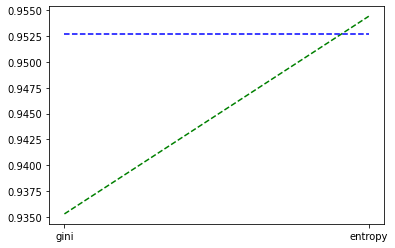

In [63]:
plt.plot(c,tr_acc, color='green', linestyle='dashed')
plt.plot(c,ts_acc, color='blue', linestyle='dashed')

plt.show()
# criterion

In [64]:
c=[]
for i in range(1,10):
  c.append(i);
tr_acc=[]
ts_acc=[]
for ind, i in enumerate(c):
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=i, splitter='best')
    clf.fit(x_train, y_train)
    tr_acc.append( accuracy_score(y_train, clf.predict(x_train)))
    ts_acc.append( accuracy_score(y_test, clf.predict(x_test)))


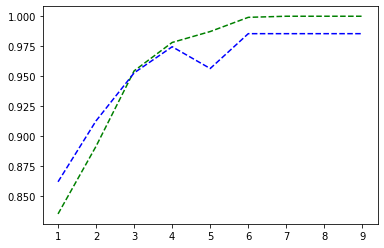

In [65]:
plt.plot(c,tr_acc, color='green', linestyle='dashed')
plt.plot(c,ts_acc, color='blue', linestyle='dashed')

plt.show()
# max depth

In [66]:
c=[]
for i in range(2,30):
  c.append(i);
tr_acc=[]
ts_acc=[]
for ind, i in enumerate(c):
    clf = DecisionTreeClassifier(min_samples_split=c[ind])
    clf.fit(x_train, y_train)
    tr_acc.append( accuracy_score(y_train, clf.predict(x_train)))
    ts_acc.append( accuracy_score(y_test, clf.predict(x_test)))


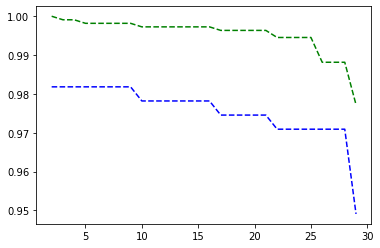

In [67]:
plt.plot(c,tr_acc, color='green', linestyle='dashed')
plt.plot(c,ts_acc, color='blue', linestyle='dashed')

plt.show()
# min samples split

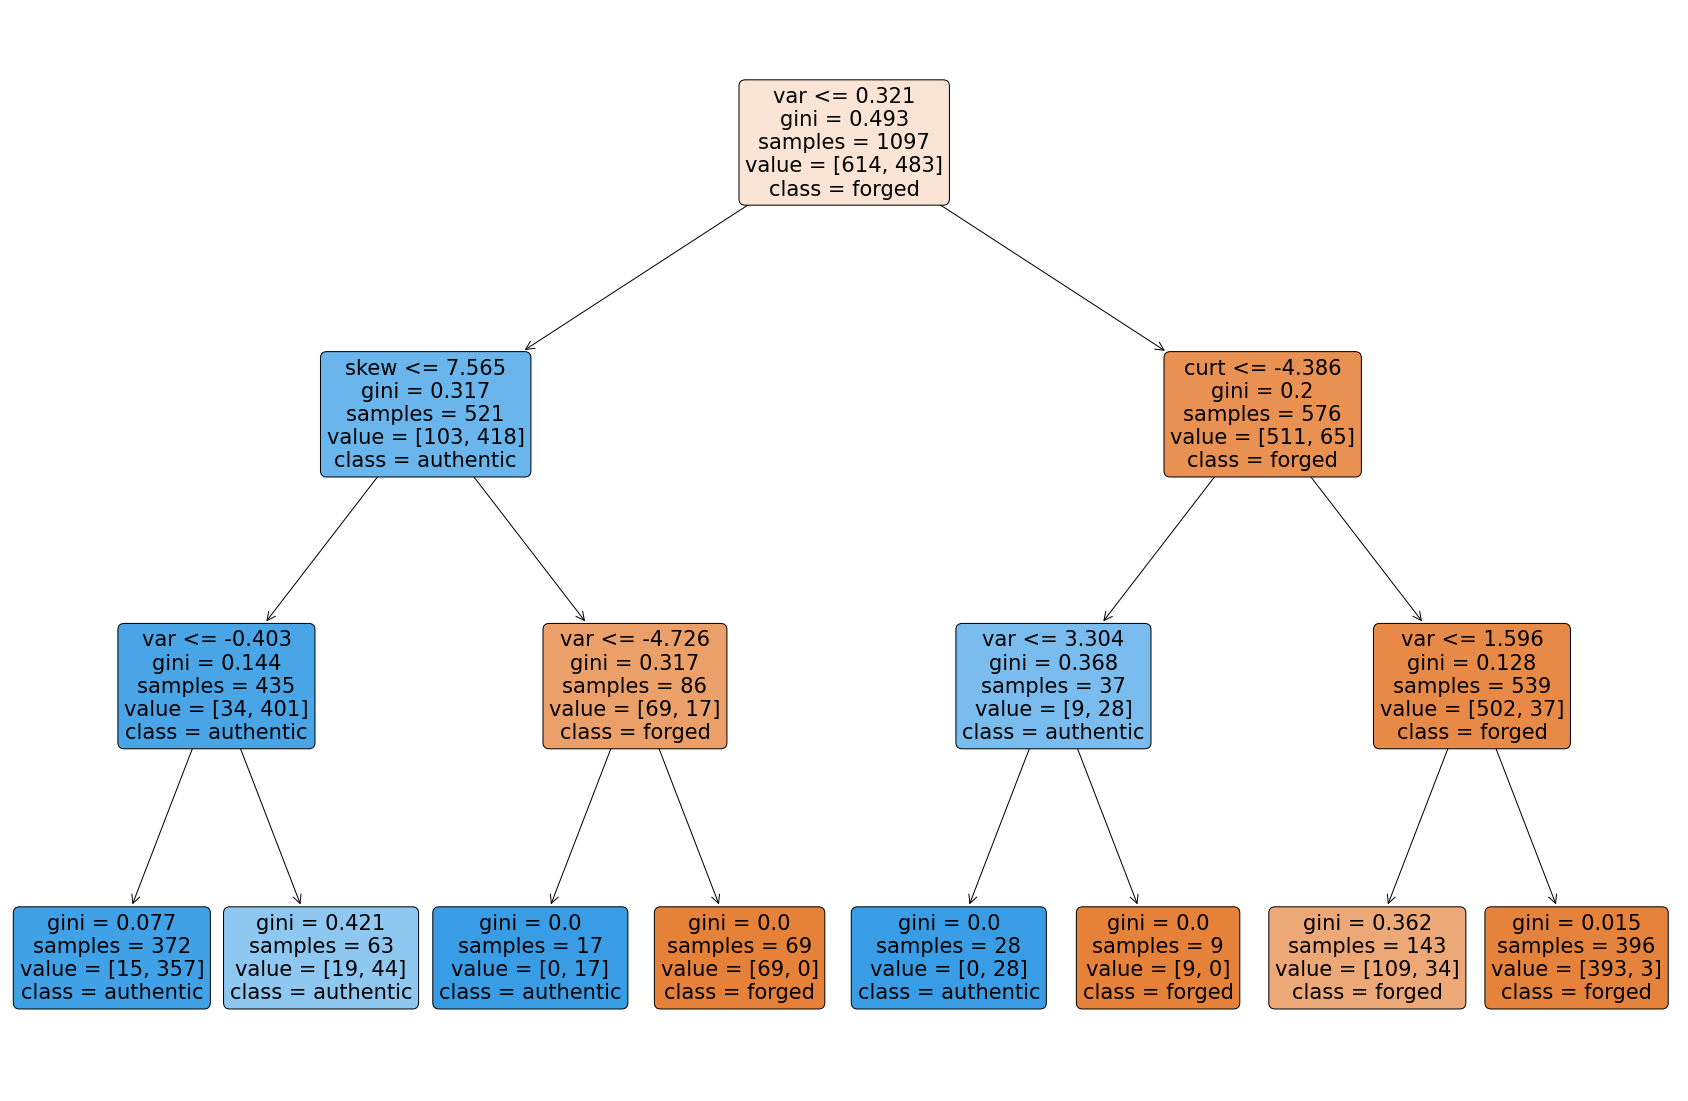

In [68]:
from sklearn.tree import plot_tree

def plotTree(tree):
    """
    tree: Tree instance that is the result of fitting a DecisionTreeClassifier
          or a DecisionTreeRegressor.
    """
    plt.figure(figsize=(30,20))
    plot_tree(tree, filled=True, rounded=True,
                  class_names=['forged', 'authentic'],
                  feature_names=['var', 'skew', 'curt', 'ent'])
    plt.show()
    return None
plotTree(DecisionTreeClassifier(max_depth=3).fit(x_train,y_train))

### Denouement

Use this place to report all comparisons and wrap up the calls to the functions written above.

The Gini index performs the best while varying across criteria. On the other hand, because log loss and entropy are the same function for binary classes, since they both exhibit the same performance.

At first, regardless of max depth, depth increase improves test and train accuracy. The training accuracy drops to 1 after depth = 5, and the test accuracy likewise begins to stabilise. However, it is clear that our model has overfitted at this point, and there is a chance that it will perform poorly. As a result, a depth of 3 or 4 is perfect for our tree.

Training accuracy steadily declines as min samples split increases while being varied. It doesn't bring any change to test accuracy.